In [1]:
import warnings
import pandas as pd
import arviz as az

import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
from libs.model import HGPforecaster, OutPiecewiseLinearChangepoints, PiecewiseLinearChangepoints
from libs.metrics import calculate_metrics, metrics_to_table
from libs.pre_processing import generate_groups_data_flat, generate_groups_data_matrix, data_transform
from libs.visual_analysis import visualize_fit, visualize_predict

import matplotlib.pyplot as plt
import pymc3 as pm
import numpy as np
import theano
import theano.tensor as tt
az.style.use('arviz-darkgrid')
warnings.filterwarnings('ignore')

In [2]:
prison = pd.read_csv('../data/prisonLF.csv', sep=",")
prison = prison.drop('Unnamed: 0', axis =1)
prison['t'] = prison['t'].astype('datetime64[ns]')

In [3]:
prison_pivot = prison.pivot(index='t',columns=['state', 'gender', 'legal'], values='count')

In [4]:
groups_input = {
    'state': [0],
    'gender': [1],
    'legal': [2]
}

In [5]:
groups = generate_groups_data_flat(prison_pivot, groups_input, seasonality=4, h=8)

Number of groups: 3
	state: 8
	gender: 2
	legal: 2
Total number of series: 32
Number of points per series for train: 40
Total number of points: 48
Seasonality: 4
Forecast horizon: 8


In [6]:
# transform the data to matrix form
g = generate_groups_data_matrix(groups)
dt = data_transform(g)

# if likelihood is normal standardize data
g = dt.std_transf_train()

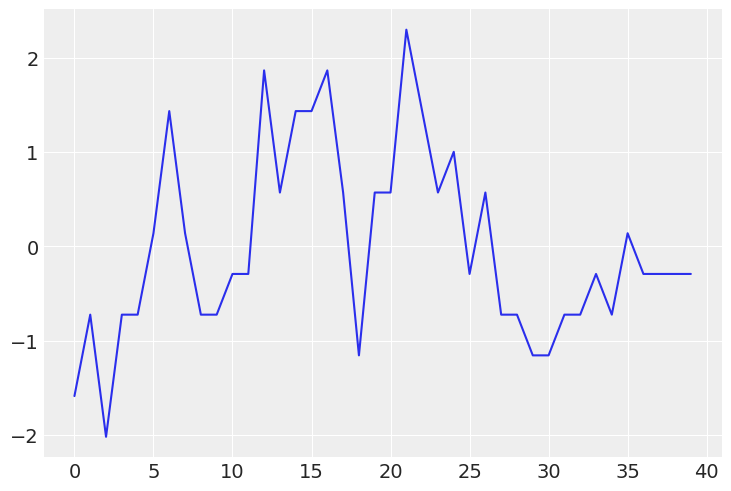

In [7]:
plt.plot(g['train']['data'].T[0]);

In [8]:
g['train']['data'] = g['train']['data'].T

In [9]:
X = np.arange(groups['train']['n']).reshape(-1,1)
X_new = np.arange(groups['predict']['n']).reshape(-1,1)

In [10]:
changepoints = 4
changepoints_t = np.linspace(0, groups['train']['n'], changepoints + 2)[1:-1]
changepoints_t

array([ 8., 16., 24., 32.])

In [11]:
class OutPiecewiseLinearChangepoints():
    # Piecewise linear function applied outside of the GPs and added in the likelihood parameter
    def __init__(self, 
                 k, 
                 m,
                 b,
                 changepoints,
                 groups):
        self.k = k
        self.m = m
        self.b = b
        self.g = groups
        self.changepoints = changepoints

    def create_changepoints(self, X, changepoints):
        return (0.5 * (1.0 + tt.sgn(tt.tile(X.reshape((-1,1)), (1,len(changepoints))) - changepoints)))

    def build(self, X):
        size_r = X.shape[0]

        X = theano.shared(X)
            
        A = self.create_changepoints(X, self.changepoints)

        piecewise = (self.k.reshape((1, -1)) + tt.dot(A, self.b))*X+ (self.m.reshape((1,-1)) + tt.dot(A, (-self.changepoints.reshape((-1,1)) * self.b)))
        
        return piecewise

In [12]:
n_samples = 200
n = groups['predict']['n']
s = groups['predict']['s']

In [13]:
p_s_fit = []
p_s_predict = []

σ_list = [0.001, 0.01]

for i in range(groups['train']['s']):
        
        for sig in σ_list:
            try:
                with pm.Model() as model:
                    period = pm.Gamma('period', 40, 10)

                    l_t = pm.InverseGamma('l_t', 4, 40)
                    l_p = pm.HalfNormal('l_p', 0.5)
                    η_trend = pm.HalfNormal('η_trend',1)
                    η_per = pm.HalfNormal('η_per',1.5)
                    print(sig)
                    σ  = pm.HalfNormal("σ",  sigma=sig)

                    mu_func = pm.gp.mean.Zero()

                    # cov function for the GP 
                    cov = (η_trend**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=l_t)
                            + η_per**2 * pm.gp.cov.Periodic(1, period=period, ls=l_p) 
                            + pm.gp.cov.WhiteNoise(σ))

                    gp = pm.gp.Latent(mean_func=mu_func, cov_func=cov)
                    f = gp.prior('f', X=X, reparameterize=True)

                    k = pm.Normal("k", mu=0, sigma=0.01)
                    m = pm.Normal("m", mu=0, sigma=0.01)
                    delta = pm.Normal("delta", mu=0, sigma=0.01, shape=(len(changepoints_t),1))

                    piece = OutPiecewiseLinearChangepoints(k = k,
                                                          m = m,
                                                          b = delta,
                                                          changepoints = changepoints_t,
                                                          groups = g).build(X)
                    piece = piece.reshape((-1,))

                    y_pred = pm.Normal('y_pred', mu=f + piece, observed=g['train']['data'][i])
                    mp = pm.find_MAP(maxeval=100, progressbar = False)
                break

            except:
                print(f'Error on fitting series {i}')
        
        try:
            with model:
                pred_samples_fit = pm.sample_posterior_predictive([mp], 
                                              vars=[y_pred], 
                                              samples=n_samples,
                                              progressbar=False)

                f_n = gp.conditional('f_n', Xnew=X_new)

                piece = OutPiecewiseLinearChangepoints(k = k,
                                                      m = m,
                                                      b = delta,
                                                      changepoints = changepoints_t,
                                                      groups = g).build(X_new)

                piece = piece.reshape((-1,))

                y_pred_new = pm.Normal("y_pred_new", 
                                        mu=f_n + piece, 
                                        shape=X_new.shape[0])

                pred_samples_predict = pm.sample_posterior_predictive([mp], 
                                                          vars=[y_pred_new], 
                                                          samples=n_samples,
                                                          progressbar = False)

            print('Predicted ' + str(i)+'/'+str(groups['train']['s']-1))
            p_s_fit.append(pred_samples_fit['y_pred'])
            p_s_predict.append(pred_samples_predict['y_pred_new'])
            
        except:
            print(f'Error on predicting series {i}')

0.001


Predicted 0/31
0.001


Predicted 1/31
0.001


Predicted 2/31
0.001


Predicted 3/31
0.001


Predicted 4/31
0.001


Predicted 5/31
0.001


Predicted 6/31
0.001


Predicted 7/31
0.001


Predicted 8/31
0.001


Predicted 9/31
0.001


Predicted 10/31
0.001


Predicted 11/31
0.001


Predicted 12/31
0.001


Predicted 13/31
0.001
Error on fitting series 14
0.01


Predicted 14/31
0.001


Predicted 15/31
0.001


Predicted 16/31
0.001


Predicted 17/31
0.001


Predicted 18/31
0.001


Predicted 19/31
0.001


Predicted 20/31
0.001


Predicted 21/31
0.001


Predicted 22/31
0.001


Predicted 23/31
0.001


Predicted 24/31
0.001


Predicted 25/31
0.001


Predicted 26/31
0.001


Predicted 27/31
0.001


Predicted 28/31
0.001


Predicted 29/31
0.001


Predicted 30/31
0.001


Predicted 31/31


In [14]:
p_s_fit = np.asarray(p_s_fit)
p_s_predict = np.asarray(p_s_predict)
p_s_fit = p_s_fit.transpose(1, 2, 0)
p_s_predict = p_s_predict.transpose(1, 2, 0)

In [15]:
g['train']['data'] = g['train']['data'].T

In [16]:
# Back transform the data and the predictions

p_s_fit_inv = dt.inv_transf_train_general(p_s_fit)
p_s_predict_inv = dt.inv_transf_predict_general(p_s_predict)
g = dt.inv_transf_train()

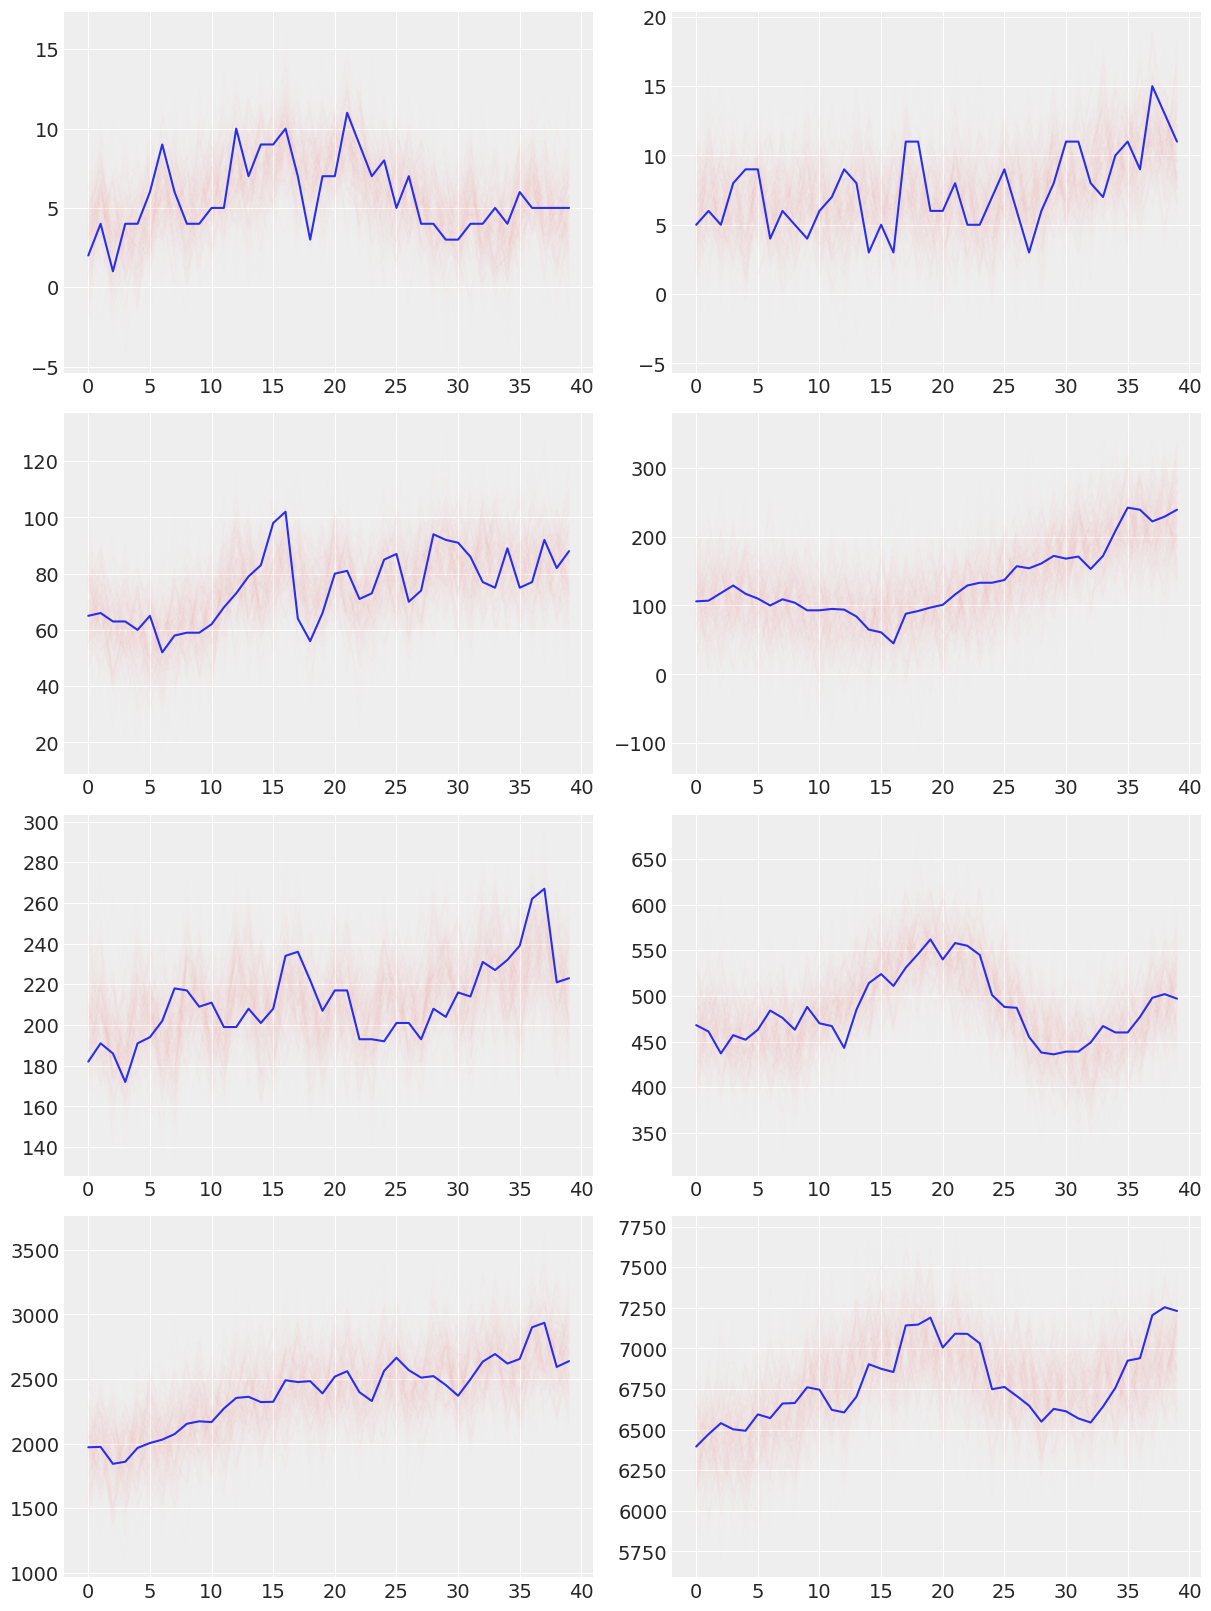

In [17]:
visualize_fit(g, p_s_fit_inv, 8)

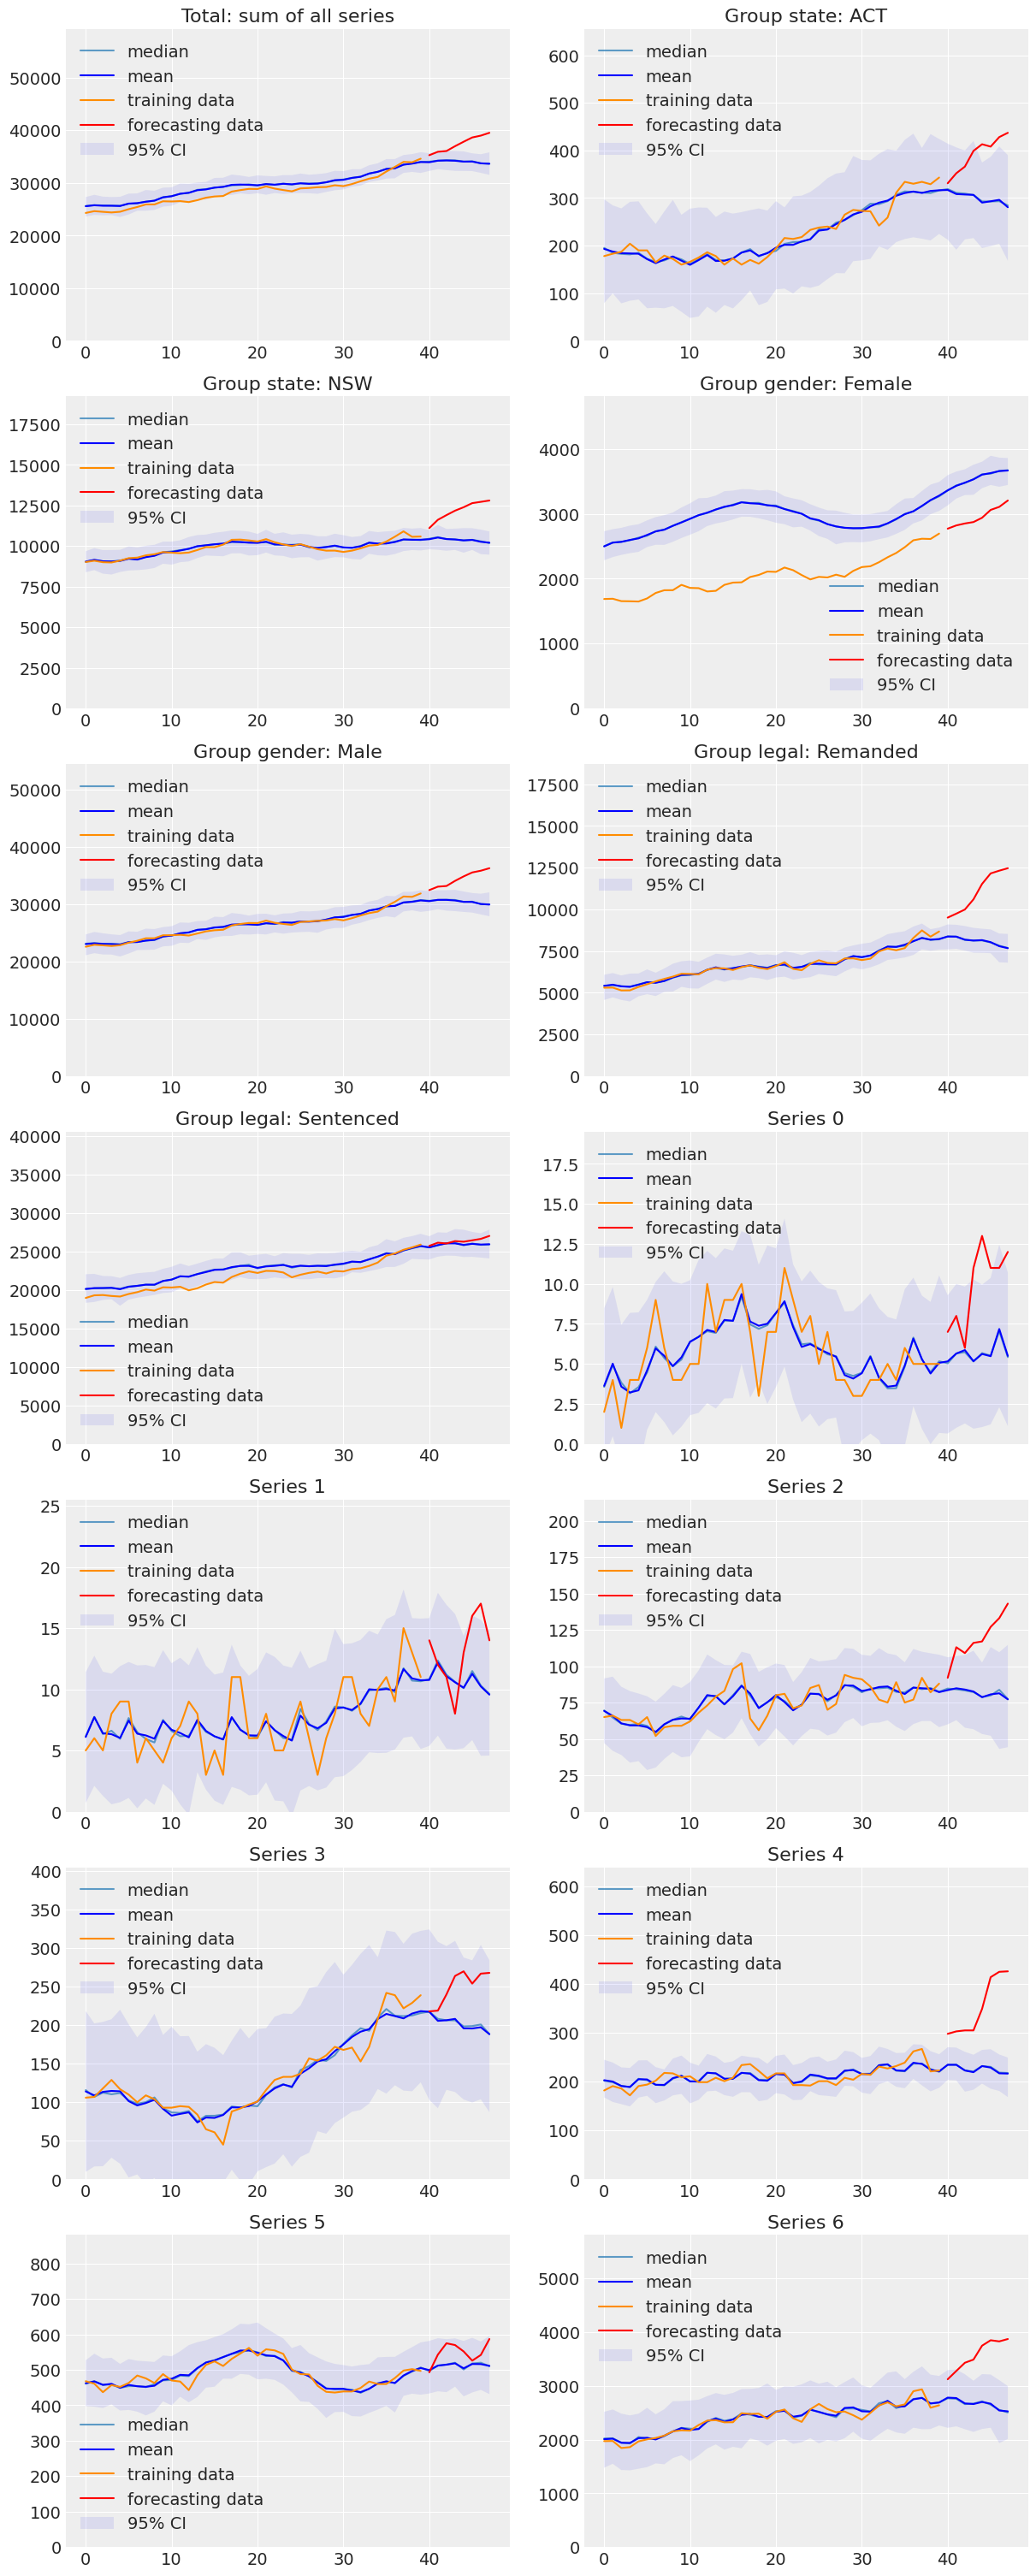

In [18]:
visualize_predict(g, p_s_predict_inv, g['h'])

In [19]:
results = calculate_metrics(p_s_predict_inv, groups)
metrics_to_table( results)

,bottom,total,state,gender,legal,all
mase,3.952,3.061,3.226,4.162,4.243,3.853
rmse,193.106,3758.933,610.291,2440.078,1893.28,589.309
